# Reflecting Cosmic Ray analysis
This notebook analyzes pairs of tracks from simulated cosmic ray events, comparing upstream and downstream properties to extract the momentum resolution and shift due to material effects.
It uses root, uproot, and standard python numerical and plotting packages.

In [2]:
import os
import uproot 
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from pathlib import Path
print("Hello world")

Hello world


This notebook processes TrkAna files constructed using the SelectReflections_module filter.
The TrkAna files contain 4 trees, one for each particle type reconstruction assumption: e+, e-, mu+, and mu-.
Each tree has the same structure, consisting of 2 tracks reconstructed from this particle: trk[0] is the upstream-going fit, trk[1] is the downstream-going fit.

In [3]:
input_dataset = np.empty
temp = np.empty
signal = np.empty
backgnd = np.empty
files = ["/global/cfs/cdirs/m3712/Mu2e/TARef_v7.root:TAReM/trkana"]
    
#time = []
up_up_time = []
up_down_time = []
down_down_time = []
upmcpdg = []
downmcpdg = []
up_px = []
up_py = []
up_pz = []
down_px = []
down_py = []
down_pz = []
nipa_up = []
nipa_down = []
nst_up = []
nst_down = []
for batch,rep in uproot.iterate(files,filter_name="/trk|trkfit|trkmcsim/i",report=True):
    # print("Fields available in 'trkfit':", ak.fields(batch["trkfit"]))
    # upstream and downstream tracks
    upstream = batch["trkfit"][:,0]
    downstream = batch["trkfit"][:,1]
    uptrkmcsim = batch["trkmcsim"][:,0][:,0] # primary MC particle matched to the upstream track
    downtrkmcsim = batch["trkmcsim"][:,1][:,0] # primary MC particle matched to the downstream track
    # find the samples at the tracker entrance
    up_up = (upstream["sid"] == 0) & (upstream['mom']['fCoordinates']['fZ'] < 0) # exiting the tracker
    up_down = (upstream["sid"] == 0) & (upstream['mom']['fCoordinates']['fZ'] > 0) # re-entering the tracker
    down_down = (downstream["sid"] == 0) & (downstream['mom']['fCoordinates']['fZ'] > 0) # entering the tracker
    has_up_up = ak.num(upstream[up_up]) > 0
    has_up_down = ak.num(upstream[up_down]) > 0
    has_down_down = ak.num(downstream[down_down]) > 0
    has_all = has_up_up & has_up_down & has_down_down
    up_up_time.extend(ak.flatten(upstream[has_all][up_up]['time']))
    up_down_time.extend(ak.flatten(upstream[has_all][up_down]['time']))
    down_down_time.extend(ak.flatten(downstream[has_all][down_down]['time']))
    upmcpdg.extend(uptrkmcsim['pdg'])
    downmcpdg.extend(downtrkmcsim['pdg'])
    up_px.extend(ak.flatten(upstream[has_all][up_down]['mom']['fCoordinates']['fX']))
    up_py.extend(ak.flatten(upstream[has_all][up_down]['mom']['fCoordinates']['fY']))
    up_pz.extend(ak.flatten(upstream[has_all][up_down]['mom']['fCoordinates']['fZ']))
    down_px.extend(ak.flatten(downstream[has_all][down_down]['mom']['fCoordinates']['fX']))
    down_py.extend(ak.flatten(downstream[has_all][down_down]['mom']['fCoordinates']['fY']))
    down_pz.extend(ak.flatten(downstream[has_all][down_down]['mom']['fCoordinates']['fZ']))
    #nipa_up.extend(uptrk['nipaup'])
    nipa_up.extend(batch["trk.nipaup"][:,0]) # only need upstream track for material intersection counting
    nipa_down.extend(batch["trk.nipadown"][:,0])
    nst_up.extend(batch["trk.nstup"][:,0])    
    nst_down.extend(batch["trk.nstdown"][:,0])
deltapdg = np.subtract(upmcpdg,downmcpdg)
decay = []
for dpdg in deltapdg :
    decay.append(dpdg != 0)
decay = np.array(decay)

#print("NIPA_up",len(nipa_up),nipa_up[:10])

up_px = np.square(up_px)
up_py = np.square(up_py)
up_pz = np.square(up_pz)
down_px = np.square(down_px)
down_py = np.square(down_py)
down_pz = np.square(down_pz)
up_mom = np.sqrt(np.add(up_px,up_py,up_pz))
down_mom = np.sqrt(np.add(down_px,down_py,down_pz))

nipa = np.add(nipa_up,nipa_down)
nst = np.add(nst_up,nst_down)
nmat = np.add(nipa,nst)

print("Upstream momentum ",up_mom[:10])
print("Downstream momentum ",down_mom[:10])
print("Upstream fit upstream time ",len(up_up_time),up_up_time[:10])
print("Upstream fit downstream time",len(up_down_time),up_down_time[:10])
print("Downstream fit downstream time",len(down_down_time),down_down_time[:10])
print("Upstream MC PDG code",len(upmcpdg),upmcpdg[:10])
print("Downstream MC PDG code",len(downmcpdg),downmcpdg[:10])
print("Decays ",decay.sum())    
print("N ST ",nst[:10]," N IPA ",nipa[:10], "N mat ", nmat[:10])

Upstream momentum  [82.07796  75.36583  67.59767  58.463898 68.480675 63.87098  62.77167
 71.96335  56.92102  55.0708  ]
Downstream momentum  [82.70859  71.720894 67.31138  54.901886 69.2935   53.435535 63.987545
 72.974846 56.425304 54.29911 ]
Upstream fit upstream time  10845 [1058.8132499565834, 791.2595864891081, 631.1596816295064, 1157.0246589749927, 863.8595146052817, 978.5759806240161, 481.6281126014945, 916.8505660404207, 1141.601805605004, 1362.4950431645411]
Upstream fit downstream time 10845 [1111.7131491620162, 848.0066844004847, 682.1531754384955, 1226.6696936533208, 921.3555891737991, 1029.7148536170612, 542.8695526806285, 971.3281016892062, 1204.2884061798172, 1421.540853948377]
Downstream fit downstream time 10845 [1111.3902684690056, 845.557292661109, 681.8897517678457, 1228.244761236923, 921.1102214601866, 1036.5354399233238, 545.2202117356964, 971.0875856452898, 1207.3757852413721, 1422.1941870112166]
Upstream MC PDG code 10845 [11, 11, 11, 11, 11, -11, 11, 11, 11, 1

Label true elec

In [4]:
true_em = []
true_mum = []
for mcpdg in upmcpdg :
    true_em.append(mcpdg == 11)
    true_mum.append(mcpdg == 13)
true_em = np.array(true_em)
true_mum = np.array(true_mum)
print("True Electrons",len(true_em),true_em[:10])
print("True Muons",len(true_mum),true_mum[:10])


True Electrons 10845 [ True  True  True  True  True False  True  True  True  True]
True Muons 10845 [False False False False False False False False False False]


N true electrons  9432  N true muons  1409


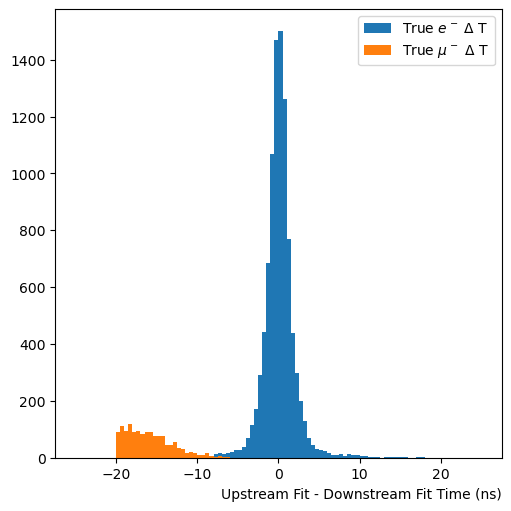

In [20]:
time_diff = np.subtract(up_down_time,down_down_time)
em_time_diff = time_diff[true_em]
mum_time_diff = time_diff[true_mum]
print("N true electrons ",len(em_time_diff), " N true muons ", len(mum_time_diff))
fig, ax = plt.subplots(layout='constrained', figsize=(5, 5))
ehist = ax.hist(em_time_diff,label="True $e^-$ $\Delta$ T", bins=100,range=(-25,25))
muhist = ax.hist(mum_time_diff,label="True $\mu^-$ $\Delta$ T", bins=100,range=(-25,25))
ax.set_xlabel('Upstream Fit - Downstream Fit Time (ns)',loc='right')
ax.legend()

In [6]:
abs_time_diff = np.absolute(time_diff)
good_em = []
max_tdiff = 5.0
for tdiff in abs_time_diff :
    good_em.append( tdiff <  max_tdiff)
print("Good electron ",len(good_em),good_em[:10])
good_em = np.array(good_em)
true_good_em = good_em[true_em]
eff = good_em.sum()/true_em.sum()
pur = true_good_em.sum()/good_em.sum()
print("For Delta T < ", max_tdiff , " efficiency = ",eff," purity = ",pur)

Good electron  10845 [True, True, True, True, True, False, True, True, True, True]
For Delta T <  5.0  efficiency =  0.9662849872773537  purity =  0.999780557384244


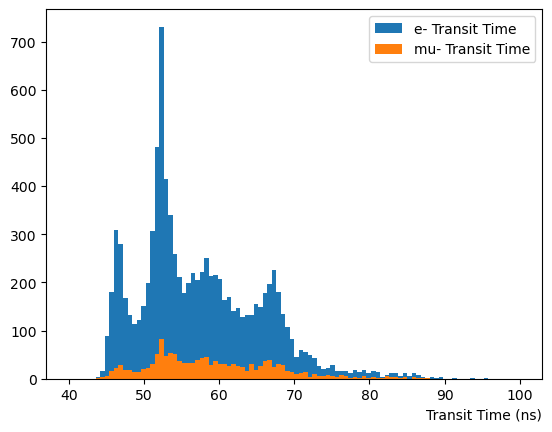

In [8]:
transit_time = np.subtract(up_down_time,up_up_time)
em_transit_time = transit_time[true_em]
mum_transit_time = transit_time[true_mum]
plt.hist(em_transit_time,label="e- Transit Time", bins=100,range=(40,100))
plt.hist(mum_transit_time,label="mu- Transit Time", bins=100,range=(40,100))
plt.xlabel('Transit Time (ns)', loc='right')
plt.legend()

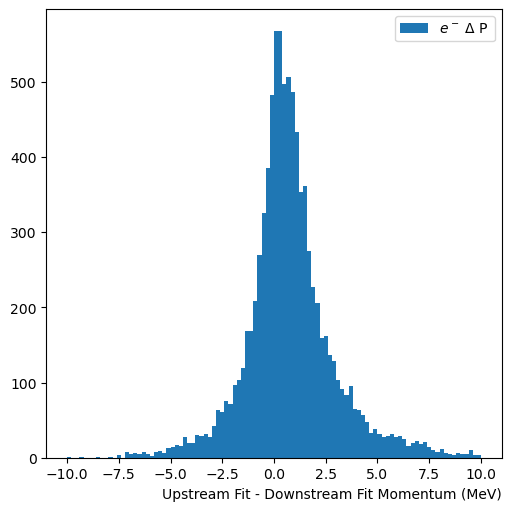

In [23]:
mom_diff = np.subtract(up_mom,down_mom)
nomat = []
for nm in nmat :
    nomat.append( nm ==0 )
nomat = np.array(nomat)
good_em_nomat = np.logical_and(nomat,good_em)

em_mom_diff = mom_diff[good_em]
em_mom_diff_nomat = mom_diff[good_em_nomat]
nmat_good = nmat[good_em]
up_mom_good = up_mom[good_em]

#fig, (ax0, ax1, ax2)  = plt.subplots(1,3,layout='constrained', figsize=(15,4))
fig, (ax0)  = plt.subplots(1,1,layout='constrained', figsize=(5,5))
#ax0.hist(em_mom_diff,label="$e^-$ $\Delta$ P", histtype='step', bins=100,range=(-10,10))
ax0.hist(em_mom_diff,label="$e^-$ $\Delta$ P",bins=100,range=(-10,10))
#ax0.hist(em_mom_diff_nomat,label="e- Upstream - Downstream Momentum (No Material)", histtype='step', bins=100,range=(-10,10))
ax0.set_xlabel("Upstream Fit - Downstream Fit Momentum (MeV)",loc='right')
ax0.legend()
#ax1.hist2d(nmat_good,em_mom_diff,bins=(15,100),range=([0,15],[-5,5]),norm=mpl.colors.LogNorm())
#ax1.set_xlabel("N Material Xings",loc='right')
#ax1.set_ylabel("Delta P (MeV)",loc='top')
#ax2.hist2d(up_mom_good,em_mom_diff,bins=(20,100),range=([40,150],[-5,5]),norm=mpl.colors.LogNorm())
#ax2.set_xlabel("Upstream P (MeV)",loc='right')
#ax2.set_ylabel("Delta P (MeV)",loc='top')